Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [48]:
import math
import time
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, roc_auc_score, make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split,cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from catboost import CatBoostClassifier,CatBoostRegressor, CatBoost
from lightgbm import LGBMRegressor

### Gather Data

In [2]:
df = pd.read_csv('/datasets/car_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

Price  RegistrationYear          Power        Mileage  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

In [5]:
df = df.rename(columns={'DateCrawled':'date_crawled',
                       'Price':'price',
                       'VehicleType':'vehicle_type',
                       'RegistrationYear':'registration_year',
                       'Gearbox':'gearbox',
                       'Power':'power',
                       'Model':'model',
                       'Mileage':'mileage',
                       'RegistrationMonth':'registration_month',
                       'FuelType':'fuel_type',
                       'Brand':'brand',
                       'NotRepaired':'not_repaired',
                       'DateCreated':'date_created',
                       'NumberOfPictures':'number_of_pictures',
                       'PostalCode':'postal_code',
                       'LastSeen':'last_seen'})
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [6]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%d/%m/%Y %H:%M')
df['date_created'] = pd.to_datetime(df['date_created'], format='%d/%m/%Y %H:%M')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%d/%m/%Y %H:%M')

### Empty Cells

Let's find out exactly how many empty cells we are working with.

In [7]:
for col in df.columns:
    print(f'{col}: {df[df[col].isna()][col].isna().count()}')

date_crawled: 0
price: 0
vehicle_type: 37490
registration_year: 0
gearbox: 19833
power: 0
model: 19705
mileage: 0
registration_month: 0
fuel_type: 32895
brand: 0
not_repaired: 71154
date_created: 0
number_of_pictures: 0
postal_code: 0
last_seen: 0


In [8]:
#for col in ['vehicle_type','gearbox','fuel_type','not_repaired','model']:
df = df.fillna('NaN')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   mileage             354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

### Duplicates

In [10]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354107 non-null  datetime64[ns]
 1   price               354107 non-null  int64         
 2   vehicle_type        354107 non-null  object        
 3   registration_year   354107 non-null  int64         
 4   gearbox             354107 non-null  object        
 5   power               354107 non-null  int64         
 6   model               354107 non-null  object        
 7   mileage             354107 non-null  int64         
 8   registration_month  354107 non-null  int64         
 9   fuel_type           354107 non-null  object        
 10  brand               354107 non-null  object        
 11  not_repaired        354107 non-null  object        
 12  date_created        354107 non-null  datetime64[ns]
 13  number_of_pictures  354107 no

Let's do one quick check at some of the unique values that are included in the DataFrame and possibly remove any outcasts that don't make any sense in this context.

In [11]:
for col in df.columns:
    print(f'{col}:\n{df[col].unique()}\n\n')

date_crawled:
['2016-03-24T11:52:00.000000000' '2016-03-24T10:58:00.000000000'
 '2016-03-14T12:52:00.000000000' ... '2016-03-27T12:42:00.000000000'
 '2016-03-08T00:49:00.000000000' '2016-03-06T21:11:00.000000000']


price:
[  480 18300  9800 ... 12395 18429 10985]


vehicle_type:
['NaN' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


registration_year:
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 

There are some absurd registration years like 3500, 9996, etc. Any records with these years will be dropped.

In [12]:
df = df.loc[(df['registration_year']>=1900) & (df['registration_year']<=2024)]
display(df['registration_year'].unique())

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1960, 1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956,
       1941, 1962, 1929, 1957, 1940, 1949, 2019, 1937, 1951, 1953, 1933,
       1950, 1948, 1952, 1932, 1942, 1935, 1936, 1923, 1930, 1944, 1943,
       1934, 1938, 1928, 1919, 1931, 1915, 1920, 1947, 1927, 1946])

## Model training

In [13]:
categorical_features = ['vehicle_type',
               'gearbox',
               'model',
               'fuel_type',
               'brand',
               'not_repaired']

There will be way too many columns if we don't drop some useless features, and will make models very inefficient. Let's find some columns in the original dataframe to drop as features. 

- date_created will not provide much value to training a model
- date_crawled is useless for our models
- last_seen is also useless for the models
- number_of_pictures does not help determine price
- postal_code is useless

In [14]:
features = df.drop(['price','date_created','date_crawled','last_seen','number_of_pictures','postal_code'],axis=1)
target = df['price']

In [15]:
ohe = pd.get_dummies(data = features, columns = categorical_features, drop_first=True)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(ohe, target, test_size=.3, random_state=42)

In [16]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.3, random_state=42)

In [17]:
numerical_features = ['registration_year','mileage','power']
scaler = StandardScaler().fit(features_train_ohe[numerical_features])

In [18]:
features_train[numerical_features] = scaler.transform(features_train[numerical_features])
features_test[numerical_features] = scaler.transform(features_test[numerical_features])

In [19]:
features_train.shape

(247755, 10)

In [20]:
features_test.shape

(106181, 10)

In [21]:
features_train_ohe[numerical_features] = scaler.transform(features_train_ohe[numerical_features])
features_test_ohe[numerical_features] = scaler.transform(features_test_ohe[numerical_features])

In [22]:
features_train_ohe.shape

(247755, 312)

In [23]:
features_test_ohe.shape

(106181, 312)

In [24]:
model_quality = pd.DataFrame(columns=('fit_time','score_time','RMSE'))

In [25]:
def rmse(y_true, y_predict):
    mse = mean_squared_error(y_true, y_predict)
    return mse**0.5

In [26]:
lr = LinearRegression()

In [27]:
start_fit = time.time()
lr.fit(features_train_ohe, target_train_ohe)
end_fit = time.time()

In [28]:
start_predictions = time.time()
predictions = lr.predict(features_test_ohe)
end_predictions = time.time()

In [29]:
lr_rmse = rmse(target_test_ohe, predictions)

In [30]:
lr_quality = ['Linear Regression']
lr_quality.append(end_fit-start_fit)
lr_quality.append(end_predictions-start_predictions)
lr_quality.append(lr_rmse)

In [31]:
model_quality.loc['Linear Regression'] = [(end_fit-start_fit),(end_predictions-start_predictions),lr_rmse]
model_quality.head()

fit_time  score_time         RMSE
Linear Regression  20.349388    0.191628  2903.561561

In [32]:
cbr_parameters = {
"random_state":[42],
"iterations":[*range(100,1000,100)],
"depth":[*range(10,100,10)],
"learning_rate":[0.01,0.03,0.1,0.25,0.5,1]}

In [33]:
cbr = GridSearchCV(CatBoostRegressor(),
                  cbr_parameters,
                  cv=5,
                  scoring='neg_mean_squared_error',
                  refit='neg_mean_squared_error').fit(features_train_ohe,target_train_ohe)

0:	learn: 4480.6030900	total: 171ms	remaining: 17s
1:	learn: 4449.8115283	total: 278ms	remaining: 13.6s
2:	learn: 4420.0812323	total: 385ms	remaining: 12.5s
3:	learn: 4389.8855417	total: 503ms	remaining: 12.1s
4:	learn: 4360.5586637	total: 623ms	remaining: 11.8s
5:	learn: 4331.6109880	total: 743ms	remaining: 11.6s
6:	learn: 4302.7933106	total: 865ms	remaining: 11.5s
7:	learn: 4274.1757341	total: 988ms	remaining: 11.4s
8:	learn: 4245.7629764	total: 1.11s	remaining: 11.2s
9:	learn: 4218.1281713	total: 1.23s	remaining: 11.1s
10:	learn: 4190.7161561	total: 1.33s	remaining: 10.8s
11:	learn: 4163.6919142	total: 1.45s	remaining: 10.6s
12:	learn: 4137.3099895	total: 1.57s	remaining: 10.5s
13:	learn: 4111.1947488	total: 1.69s	remaining: 10.4s
14:	learn: 4085.0787713	total: 1.81s	remaining: 10.3s
15:	learn: 4058.9356788	total: 1.93s	remaining: 10.1s
16:	learn: 4033.5845650	total: 2.05s	remaining: 10s
17:	learn: 4008.7506955	total: 2.17s	remaining: 9.9s
18:	learn: 3983.6773629	total: 2.29s	remain

In [40]:
cbr_results = cbr.cv_results_
best_index = cbr.best_index_
average_fit_time = cbr_results['mean_fit_time'][best_index]
average_score_time = cbr_results['mean_score_time'][best_index]
rmse = (cbr.best_score_*-1)**0.5

In [41]:
model_quality.loc['Cat Boost Regression'] = [average_fit_time, average_score_time, rmse]
model_quality.head()

fit_time  score_time         RMSE
Linear Regression      20.349388    0.191628  2903.561561
Cat Boost Regression  109.569771    0.304222  1701.627474
Random Forest          19.773931    0.334699  2907.595758

In [38]:
rfr = RandomForestRegressor(random_state=42,n_estimators=5)
cv = cross_validate(lr, ohe, target, cv=3, scoring='neg_mean_squared_error')
average_fit_time = cv['fit_time'].mean()
average_score_time = cv['score_time'].mean()
rmse = (cv['test_score'].mean()*-1)**0.5
rfr_data = [average_fit_time, average_score_time, rmse]
model_quality.loc['Random Forest'] = rfr_data
model_quality.head()

fit_time  score_time         RMSE
Linear Regression      20.349388    0.191628  2903.561561
Cat Boost Regression  109.569771    0.304222  1701.627474
Random Forest          19.773931    0.334699  2907.595758

In [52]:
for col in categorical_features:
    features_train[col] = features_train[col].astype('category')
    features_test[col] = features_test[col].astype('category')

In [58]:
lgbm_parameters = {'num_leaves': [15,30,60],
                   'learning_rate': [0.01,0.1],
                   'max_depth': [-1,100],
                   'n_jobs':[None,5,10],
                   'random_state':[42]}

In [60]:
lgbm = GridSearchCV(estimator=LGBMRegressor(),
                    param_grid=lgbm_parameters,
                    scoring='neg_mean_squared_error').fit(features_train,target_train)

In [61]:
lgbm_results = lgbm.cv_results_
best_index = lgbm.best_index_
average_fit_time = lgbm_results['mean_fit_time'][best_index]
average_score_time = lgbm_results['mean_score_time'][best_index]
rmse = (lgbm.best_score_*-1)**0.5

In [62]:
model_quality.loc['LGBM'] = [average_fit_time, average_score_time, rmse]
model_quality.head()

fit_time  score_time         RMSE
Linear Regression      20.349388    0.191628  2903.561561
Cat Boost Regression  109.569771    0.304222  1701.627474
Random Forest          19.773931    0.334699  2907.595758
LGBM                   13.386370    0.670867  1733.379666

## Model analysis

<AxesSubplot:>

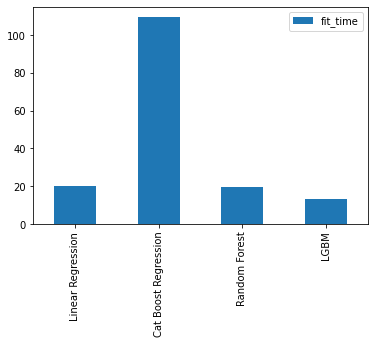

In [65]:
model_quality.plot.bar(use_index=True,y='fit_time')

<AxesSubplot:>

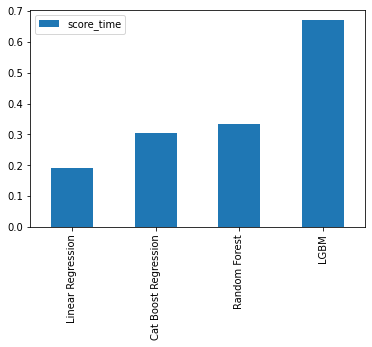

In [66]:
model_quality.plot.bar(use_index=True,y='score_time')

<AxesSubplot:>

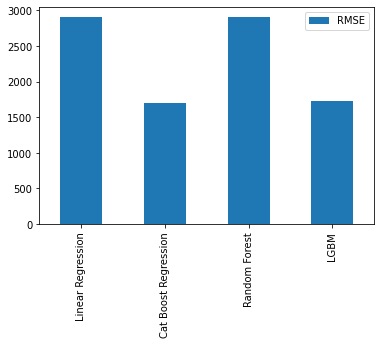

In [67]:
model_quality.plot.bar(use_index=True,y='RMSE')

In [68]:
model_quality

fit_time  score_time         RMSE
Linear Regression      20.349388    0.191628  2903.561561
Cat Boost Regression  109.569771    0.304222  1701.627474
Random Forest          19.773931    0.334699  2907.595758
LGBM                   13.386370    0.670867  1733.379666

Comparatively to the random forest model and Linear Regression model, it is clear both the speed and the quality of the model improves when we use gradient boosting. Linear regression does not have very good results, but makes a good sanity check. The random forest had almost identical results to the linear regression. However, the Cat Boosting model took a very long time to fit, but had a fabulous score. This is likely due to the very large variety of hyperparameters used. Perhaps with fewer parameters, the time would be much faster.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed